In [ ]:
#Bone Fracture Detection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install focal-loss
!pip install keras-radam

     |████████████████████████████████| 462 kB 11.9 MB/s 
  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14686 sha256=1aa40eb3d8f1c46d854506f7352a48167f998883713e68f84ee6942c4f70269d
  Stored in directory: /root/.cache/pip/wheels/23/6a/5f/d674f3b7b4d504b03148abd675e3703ba00c31763c04a2fc20
Successfully built keras-radam


In [ ]:
import os
import numpy as np
import cv2
import random
import pandas as pd
from tqdm import tqdm
import keras.backend as K
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator, load_img#, image
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from time import time


from focal_loss import BinaryFocalLoss
from keras_radam import RAdam

import datetime

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/MURA-v1.1.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Completed")

Completed


In [ ]:
def listdir_nohidden(path):
    '''
    Utility function to find the list of files in a directory excluding the hidden files.
    Args:
        path: contains the path of the directory containing the images

    '''
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [ ]:
def create_images_metadata_csv(category,study_types):
    '''
    This function creates a csv file containing the path of images, label.
    Args:
        category: train or valid, depending on which csv is needed
        study_types: the type of the body part in MURA Dataset, eg:  XR_SHOULDER
    '''
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = 'MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [ ]:
def getImageLabels(dataframe):
  '''
  This function is to get the labels of the images from the dataframe
  Args:
      dataframe: pandas dataframe containing the labels of the images

  '''
  labels = []
  for i, data in tqdm(dataframe.iterrows()):
      labels.append(data['Label'])
  labels = np.asarray(labels)
  return labels

In [ ]:
def getImage(dataframe, size):
    '''
    Function to process the images
    Args:
        dataframe: contains the path to the images in the directory
        size: contains the value to which the shape of the image will resized
    '''
    Images = []
    for i, data in tqdm(dataframe.iterrows()):
      try:
        image = cv2.imread(data['Path'])
        image = cv2.resize(image,(size,size))
        Images.append(image)

      except Exception as e:
        print(str(e))

    Images = np.asarray(Images).astype('float32')

    mean = np.mean(Images)			#normalization
    std = np.std(Images)
    Images = (Images - mean) / std
    return Images

In [ ]:
def build_model():
    base_model = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')


    x = base_model.output

    predictions = Dense(n_classes,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
###################
# Data processing #
###################

img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset

IMG_DATA_DIR = 'MURA-v1.1/'
train_data_dir = IMG_DATA_DIR + 'train/XR_HUMERUS'
valid_data_dir = IMG_DATA_DIR + 'valid/XR_HUMERUS'

train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)
study_types = ['XR_HUMERUS']

#TRAIN DATA
create_images_metadata_csv('train',study_types)
#VALID DATA
create_images_metadata_csv('valid',study_types)

100%|██████████| 132/132 [00:00<00:00, 165.16it/s]


In [ ]:
valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label'])

dd={}

dd['train'] = train_image_df
dd['valid'] = valid_image_df

In [ ]:
train_image_labels = getImageLabels(train_image_df)
train_images = getImage(train_image_df, size = 224)
train_images.shape

1272it [00:00, 14636.23it/s]
1272it [00:05, 253.05it/s]


(1272, 224, 224, 3)

In [ ]:
train_datagen.fit(train_images,augment=True)

In [ ]:
train_generator = train_datagen.flow(
    x=train_images,
    y=train_image_labels,
    batch_size = 32
)

In [ ]:
valid_image_labels = getImageLabels(valid_image_df)

288it [00:00, 10453.64it/s]


In [ ]:
valid_images = getImage(valid_image_df, size = 224)

288it [00:01, 211.01it/s]


In [ ]:
test_datagen.fit(valid_images,augment=True)

In [ ]:
validation_generator = test_datagen.flow(
    x=valid_images,
    y=valid_image_labels,
    batch_size = 1
)

In [ ]:
###################
# Construct model #
###################



#model parameters for training
#K.set_learning_phase(1)
nb_train_samples = len(train_images)
nb_validation_samples = len(valid_images)
epochs = 12
batch_size = 32
steps_per_epoch = nb_train_samples//batch_size
print(steps_per_epoch)
n_classes = 1

39


In [ ]:
#Building a model
input_shape = (224, 224, 1)
#model = densenet(input_shape, n_classes)
model = build_model()
# Build optimizer
#opt = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1)
#opt = RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-4,name='RAdam')


model.compile(loss=BinaryFocalLoss(gamma = 2), optimizer='adam', metrics=['acc', 'mse'])
#model.compile(loss=BinaryFocalLoss(gamma = 2), optimizer=opt, metrics=['acc', 'mse'])

51888128/51877672 [==============================] - 1s 0us/step


In [ ]:
#callbacks for early stopping incase of reduced learning rate, loss unimprovement
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_lr=0.0001)
callbacks_list = [early_stop, reduce_lr]

In [ ]:
#train the module
model_history = model.fit(
    train_generator,
    epochs=epochs,
    workers=0,
    use_multiprocessing=False,  
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples //batch_size,
    callbacks=callbacks_list
    
)

Epoch 1/12
39/39 [==============================] - 94s 1s/step - loss: 0.2827 - acc: 0.5484 - mse: 0.2590 - val_loss: 7.1666 - val_acc: 0.5556 - val_mse: 0.4534 - lr: 0.0010
Epoch 2/12
39/39 [==============================] - 47s 1s/step - loss: 0.1795 - acc: 0.6185 - mse: 0.2420 - val_loss: 4.0144 - val_acc: 0.5556 - val_mse: 0.3987 - lr: 0.0010
Epoch 3/12
39/39 [==============================] - 49s 1s/step - loss: 0.1574 - acc: 0.6847 - mse: 0.2201 - val_loss: 0.5166 - val_acc: 0.4444 - val_mse: 0.3525 - lr: 0.0010
Epoch 4/12
39/39 [==============================] - 49s 1s/step - loss: 0.1538 - acc: 0.6798 - mse: 0.2144 - val_loss: 0.1034 - val_acc: 0.6667 - val_mse: 0.1315 - lr: 0.0010
Epoch 5/12
39/39 [==============================] - ETA: 0s - loss: 0.1461 - acc: 0.7161 - mse: 0.2023
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
39/39 [==============================] - 49s 1s/step - loss: 0.1461 - acc: 0.7161 - mse: 0.2023 - val_loss: 0.2086 - val

In [ ]:
model.save("MURA-DenseNet-v4.h5")

In [ ]:
ev = model.evaluate(validation_generator, steps=nb_validation_samples,  workers=0, use_multiprocessing=False)
ev[1]

288/288 [==============================] - 18s 62ms/step - loss: 0.1165 - acc: 0.8194 - mse: 0.1720


0.8194444179534912

### **Performance Evaluation**

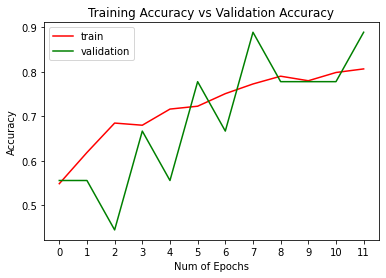

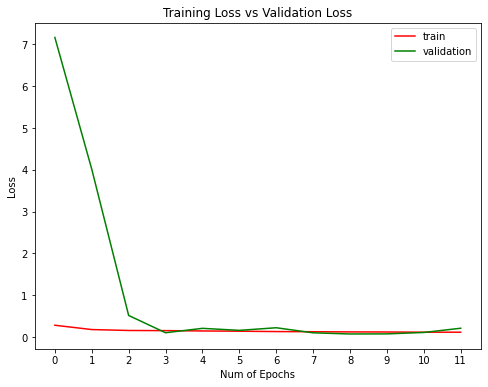

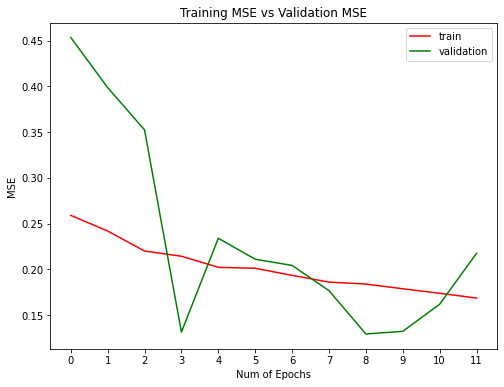

In [ ]:
#Now we have trained our model, we can see the metrics during the training proccess
plt.figure(0)
plt.plot(model_history.history['acc'],'r')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.figure(2)
plt.plot(model_history.history['mse'],'r')
plt.plot(model_history.history['val_mse'],'g')
plt.xticks(np.arange(0, 12, 1))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE")
plt.title("Training MSE vs Validation MSE")
plt.legend(['train','validation'])
 
plt.show()

In [ ]:
#pred = model.predict_generator(validation_generator, steps=1, batch_size=1, use_multiprocessing=False, max_queue_size=25, verbose=1)
validation_generator.reset()
#pred = model.predict_generator(validation_generator,steps=nb_validation_samples)
pred_batch = model.predict_on_batch(valid_images)

In [ ]:
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

In [ ]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]  
pred = predictions

### **Confusion Matric**

Confusion Matrix


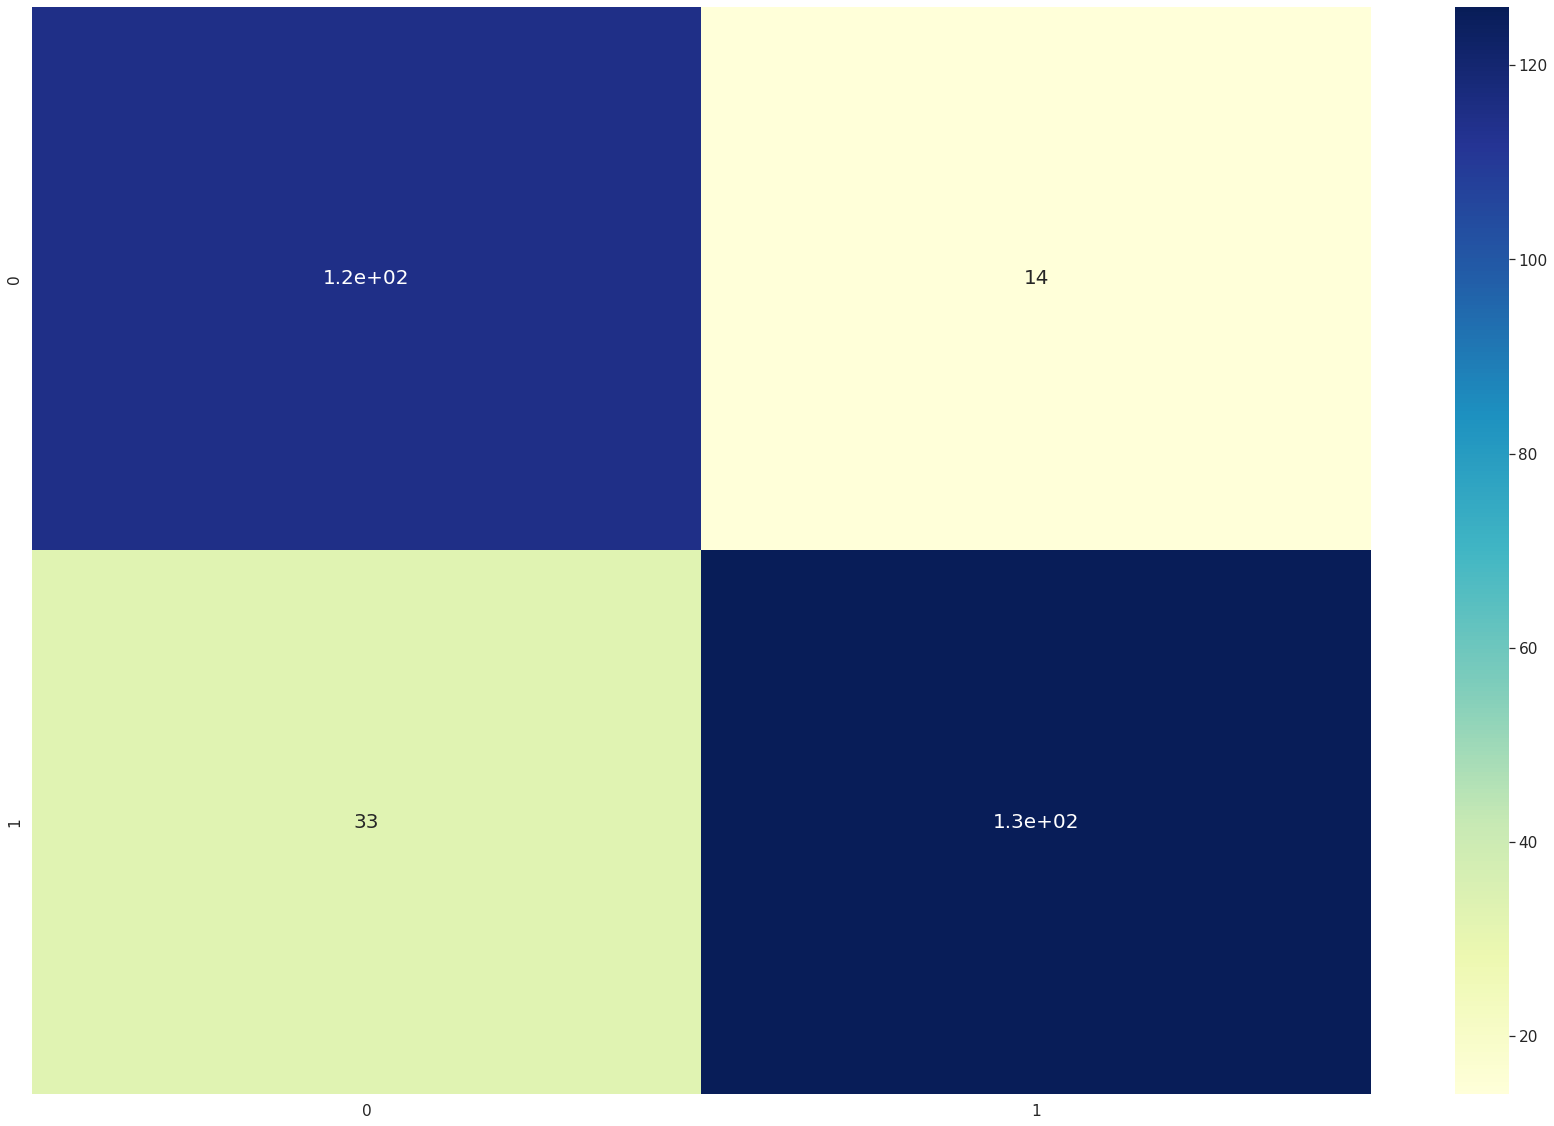

In [ ]:
print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred ,valid_image_labels)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

### **Kappa score**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_image_labels, pred)

0.6745527986151183

In [ ]:
import tensorflow.keras as tf
mymodel = tf.models.load_model("/content/MURA-DenseNet-v4.h5")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
img = image.load_img('/content/normal.jpg',target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)   # flattening
ypred = mymodel.predict(img)
if ypred[0][0] == 1:
  print("not Fractured")
else:
  print("Fractured")

not Fractured
